In [29]:
import pyaudio
import numpy as np
import scipy.stats as sts
import scipy.signal as sgl
import matplotlib.pyplot as plt

### Aufgabe 1

##### a)
Schreiben Sie ein Python-Programm zur Aufnahme kurzer akustischer Signale über die Soundkarte mithilfe des Objektes audiorecorder. Orientieren Sie sich dabei an dem in Moodle zur Verfügung gestellten Codebeispiel (J.Keppler). Speichern Sie das Signal mit einem automatisch generierten eindeutigen Namen mithilfe des Befehls numpy.save(). Nehmen Sie als Beispiel eine beliebige Spracheingabe auf und stellen Sie diese mit korrekter Achsenbeschriftung als Diagramm dar.

##### b)
 Ergänzen Sie Ihr Aufnahmeprogramm um eine Triggerfunktion, die alle Samples nahe an 0 abschneidet, die vor dem eigentlichen Beginn des Signals aufgenommen wurden (s. Codebeispiel). Auf diese Weise stellen Sie sicher, dass alle Signale bei den späteren Vergleichsoperation zum gleichen Zeitpunkt beginnen. Schneiden Sie Ihr Signal ab dem Triggerzeitpunkt so aus, dass das ausgeschnittene Signal genau 1 s lang ist und füllen im Programm die möglicherweise fehlenden Samples mit Nullen auf. Überprüfen Sie die Korrektheit Ihrer Triggerfunktion durch erneute Darstellung des Signals als Diagramm

ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card


done
Start: 11075


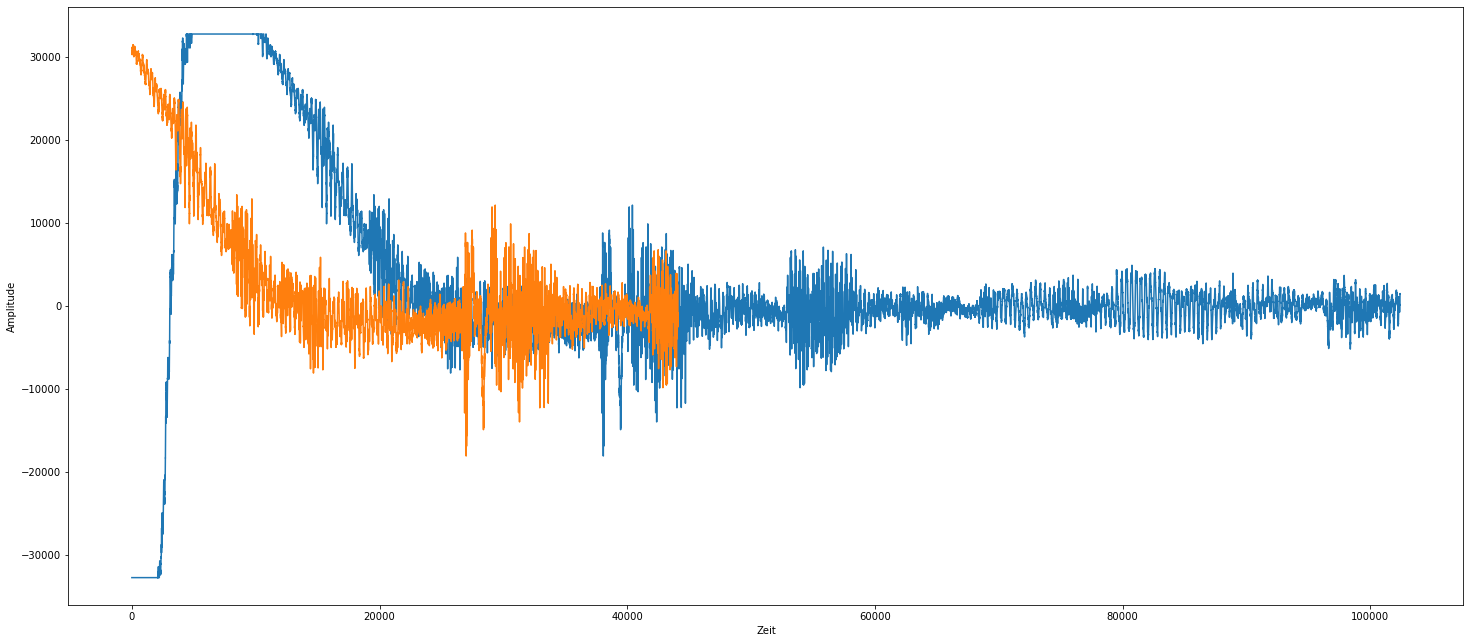

In [36]:
#Aufnahme

# a) + b)

FORMAT = pyaudio.paInt16
SAMPLEFREQ = 44100
FRAMESIZE = 1024
NOFFRAMES = 100


p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,channels=1,rate=SAMPLEFREQ,input=True,frames_per_buffer=FRAMESIZE)

data = stream.read(NOFFRAMES*FRAMESIZE)
decoded = np.frombuffer(data, np.int16)
#Zur Info: frombuffer da fromstring nicht mehr funktioniert


stream.stop_stream()
stream.close()

p.terminate()

print('done')



count = 8000
start = 0
end = 0


for i in decoded[0:len(decoded)]:
    if i > 500:
        start = count
        print("Start: " + str(start))
        break
    count += 1

trigger = decoded[start:start + SAMPLEFREQ]
#Samplefreq ist genau die Zahl der Abtastungen in einer Sekunde


np.save('sound', trigger)

plt.figure(figsize=(25, 11))

plt.plot(decoded)
plt.plot(trigger)

plt.xlabel("Zeit")
plt.ylabel("Amplitude")

plt.show()


##### c)
Bestimmen Sie mithilfe Ihres Codes aus Versuch 3 das Amplitudenspektrum des ausgeschnittenen Signals und stellen Sie dieses graphisch dar.

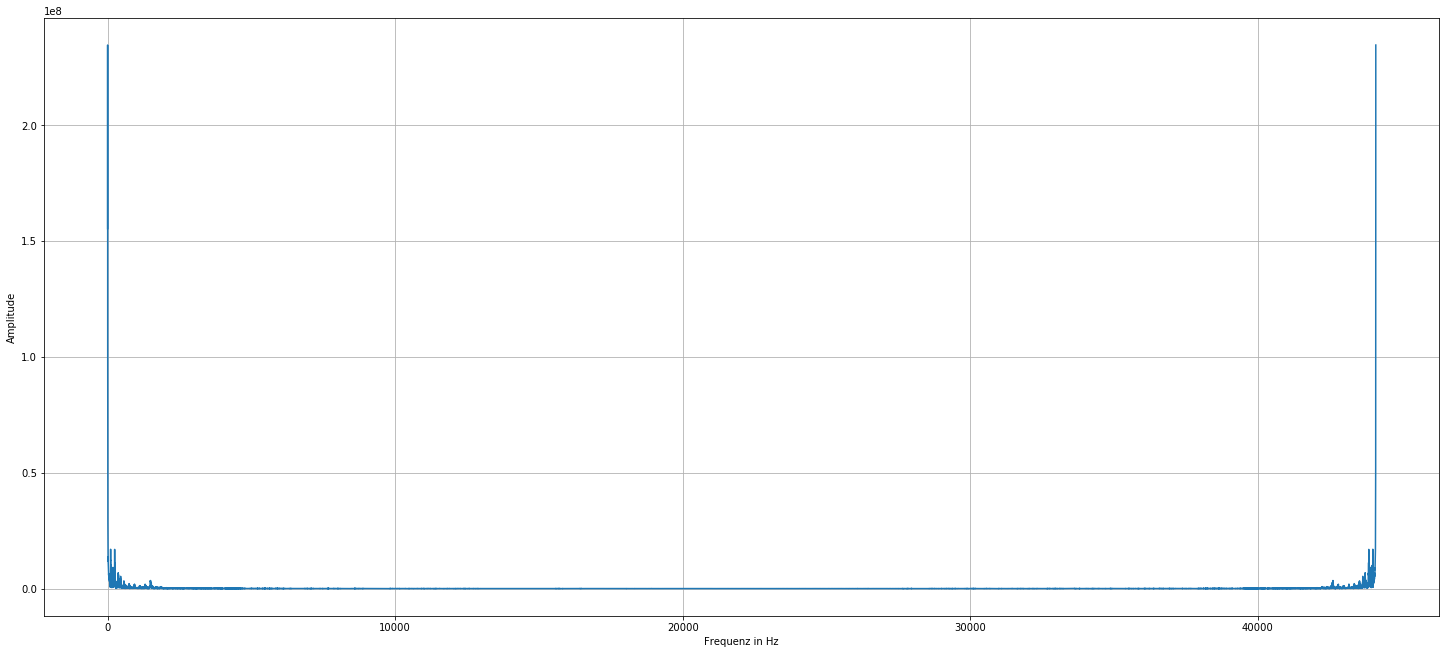

In [31]:
#Amplitudenspektrum

#c)

data = np.load("sound.npy")

ft = np.fft.fft(data)
t = 1

fq = []
for i in range(len(ft)):
    fq.append(i / t)


fig, ax = plt.subplots(figsize=(25, 11))
ax.grid()

ax.plot(fq, np.abs(ft))

ax.set_xlabel('Frequenz in Hz')
ax.set_ylabel('Amplitude')

#xWerte = np.arange(0, 8000, 890).tolist()
#ax.set_xticks(xWerte)


plt.show()

##### d)
Implementieren Sie die in der Vorlesung gezeigte Methode des Windowing. Zerlegen Sie dazu das Signal in Abschnitte mit einer Länge von 512 Samples, die sich jeweils zur Hälfte überlappen. Gewichten Sie die Samples in jedem Fenster mit einer Gaußschen Fensterfunktion, die so gewählt wird, dass die Fensterbreite 4 Standardabweichungen entspricht. Führen Sie in jedem Fenster eine lokale Fouriertransformation durch und mitteln Sie dann die Fouriertransformierte über alle Fenster. Berechnen Sie daraus wieder das Amplitudenspektrum und überprüfen Sie die Korrektheit durch Vergleich der graphischen Darstellung mit dem Spektrum aus der vorigen Teilaufgabe

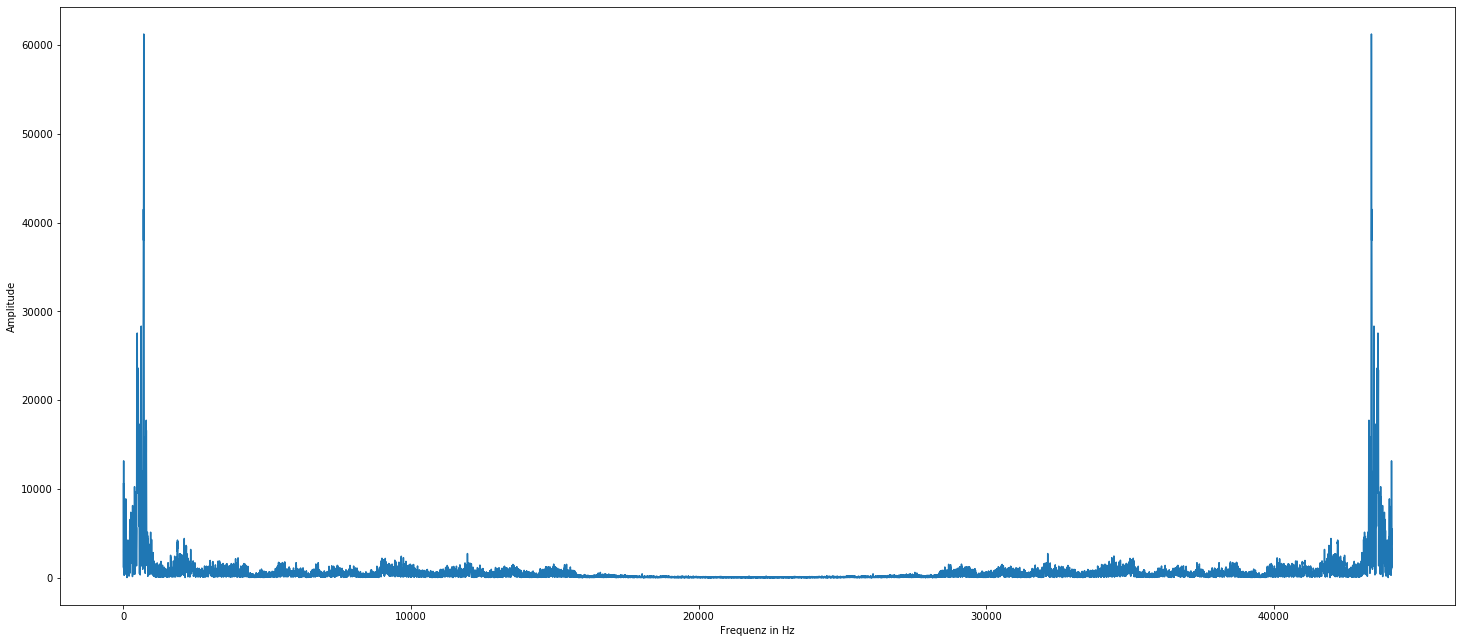

In [32]:
# Windowing

#d)

SAMPLES = 512
STD = 128

data = np.load("rechts1.npy")
# Signal in Abschnitte von 512 Samples


#-------Code nicht anpassen - wird weiter unten noch gebraucht--------------
#---------------------------------------------------------------------------
def windowing(array):
    # Fehler von Pycharm - Folgende Errorbehandlung für andere IDEs nicht notwendig
    # noinspection PyUnresolvedReferences
    window = np.array(sgl.gaussian(SAMPLES, STD))
    for index in range(0, len(array) - SAMPLES + 1, SAMPLES):
        yield np.concatenate([[0] * index, list(window * array[index:(index + SAMPLES)]), [0] * (len(array) - (index + SAMPLES))])

def localfourier(array):
    window = np.array(list(windowing(array)))
    return np.fft.fft(window).mean(0)
#----------------------------------------------------------------------------


ffts = localfourier(data)
ft = np.fft.fft(data)
t = 1

fq = []
for i in range(len(ft)):
    fq.append(i / t)


fig2, ax2 = plt.subplots(figsize=(25, 11))

ax2.plot(fq, np.abs(ffts))

ax2.set_xlabel('Frequenz in Hz')
ax2.set_ylabel('Amplitude')

plt.show()


### Aufgabe 2

##### a)
Für den Spracherkenner brauchen wir zunächst die Referenzspektren für die vier Befehle ”Hoch”, ”Tief”, ”Links” und ”Rechts”. Nehmen Sie dazu jeweils 5 Beispiele pro Befehl auf und berechnen Sie deren Spektren mit der Windowing-Methode aus Aufgabe 1. Achten Sie darauf, das die 5 Beispiele vom selben Sprecher stammen. Das Referenzspektrum erhalten Sie durch Mittelung über die 5 Spektren. Stellen Sie Ihre 4 Referenzspektren im Protokoll graphisch dar.

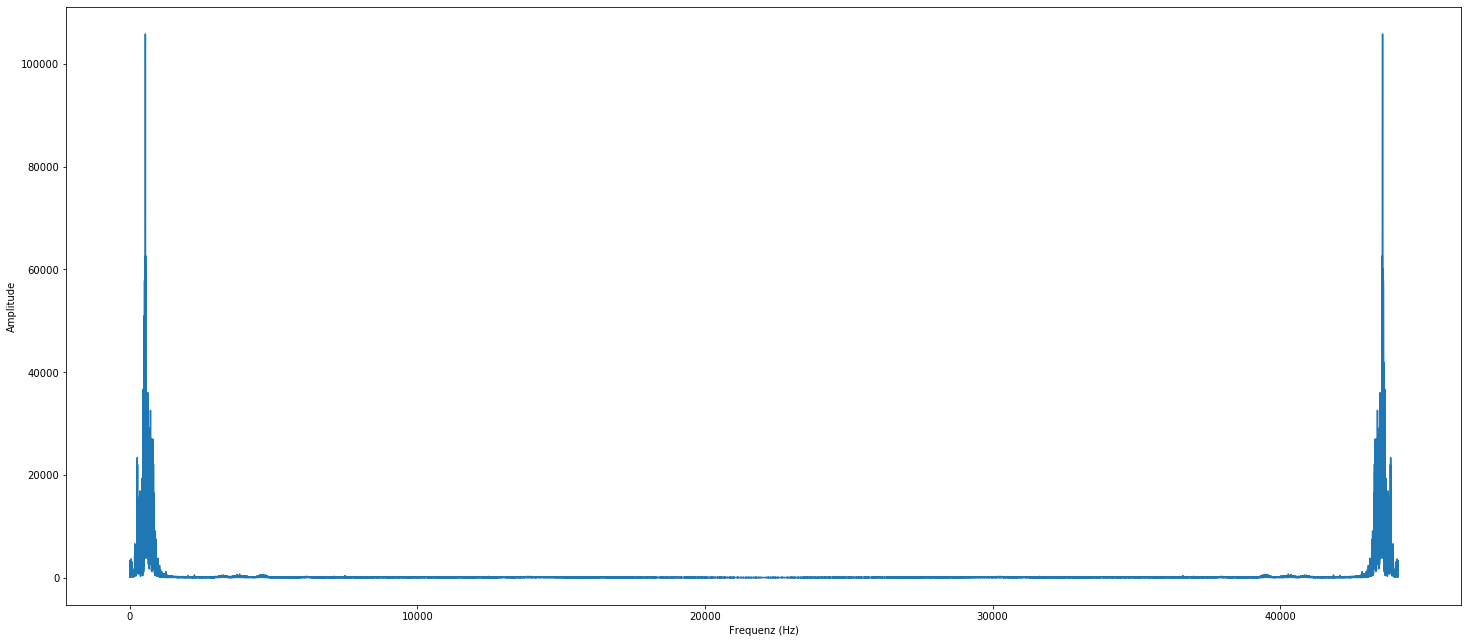

In [33]:
# Referenzspektren
# a)

def referenz(data) :
    tief = np.load("tief1.npy")
    spektren = []
    data = []
    for i in range(1,6):
        d = np.load(f'hoch{i}.npy') #Manuell überschreiben für hoch usw.
        spektren.append(localfourier(d))

    spmean = np.mean(spektren, 0)

ft = np.fft.fft(spmean)
t = 1

frequencys = []
for i in range(len(ft)):
    frequencys.append(i / t)

fig3, ax3 = plt.subplots(figsize=(25, 11))
ax3.plot(frequencys, np.abs(spmean))
ax3.set_xlabel('Frequenz (Hz)')
ax3.set_ylabel('Amplitude')

plt.show()

##### b)
Nehmen Sie einen Testdatensatz mit jeweils 5 Beispielen für jeden Befehl vom selben Sprecher wie im Trainingsdatensatz auf. Achtung: hier dürfen Sie nicht dieselben Beispiele wie im Training verwenden, ansonsten überschätzen Sie im Test die Leistungsfähigkeit Ihres Spracherkenners. Nehmen Sie zum Vergleich einen weiteren Testdatensatz gleicher Größe auf, der aber von einem anderen Sprecher stammt.

##### c)

Schreiben Sie eine Python-Routine zur Berechnung des Korrelationskoeffizienten nach Bravais-Pearson zum Vergleich zweier Eingabespektren. Testen Sie die Routine an ihren Referenzspektren: beim Vergleich identischer Spektren sollte die Korrelation 1 sein, bei verschiedenen Spektren nahe an 0.

In [34]:
# Korrelations-Prüfung
# c)
RECHTS = np.load("rechts1.npy")
LINKS = np.load("rechts4.npy")
OBEN = np.load("hoch1.npy")
UNTEN = np.load("tief1.npy")

#----------------------Visualisierung mit Seaborn-----------------------------------
import seaborn as sb
#ax = sb.lmplot(data=(RECHTS, LINKS)) #kp ob das so geht
#----------------------------------------------------------------------------------
print("KKF-rechts-rechts", sts.pearsonr(RECHTS, RECHTS)[0])
print("KKF-rechts-links", sts.pearsonr(RECHTS, LINKS)[0])

KKF-rechts-rechts 0.9999999999999999
KKF-rechts-links -0.02337452015275478


##### d)
Implementieren Sie den Spracherkenner nach der oben gezeigten Architektur und testen Sie ihn an beiden Datensätzen. Geben Sie jeweils an, wie viel Prozent der Testdaten-sätze korrekt bzw. falsch erkannt wurden (d.h. die Detektions- und die Fehlerrate) und diskutieren Sie das Ergebnis

In [35]:
#--------------------------- Aufnahme ---------------------------------

FORMAT = pyaudio.paInt16
SAMPLEFREQ = 44100
FRAMESIZE = 1024
NOFFRAMES = 100

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,channels=1,rate=SAMPLEFREQ,input=True,frames_per_buffer=FRAMESIZE)

data = stream.read(NOFFRAMES*FRAMESIZE)
decoded = np.frombuffer(data, np.int16)
#Zur Info: frombuffer da fromstring nicht mehr funktioniert


stream.stop_stream()
stream.close()

p.terminate()

#---------------------------------------------------------------------------


eingang = np.abs(localfourier(decoded))

files = [RECHTS, LINKS, OBEN, UNTEN]
kkfs = []

for j in files.length:
    kkfs[j] = sts.pearsonr(eingang, files[j])

for k in kkfs:
    if kkfs[k] == max(kkfs):
        if k == 0:
            print(f"\nrechts")
        if k == 1:
            print (f"\nlinks")
        if k == 2:
            print (f"\nhoch")
        if k == 3:
            print (f"\ntief")


ALSA lib pcm_dsnoop.c:641:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card


AttributeError: 'list' object has no attribute 'length'